In [349]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import brentq

import cvxpy as cp

In [350]:
data = pd.read_csv('../data/Stock_Bond.csv', index_col=0, parse_dates=[0], date_format='%d-%b-%y')
data.head()

,GM_Volume,GM_AC,F_Volume,F_AC,UTX_Volume,UTX_AC,CAT_Volume,CAT_AC,MRK_Volume,MRK_AC,...,XOM_Volume,XOM_AC,S&P_AC,S&P_Volume,1 year Treasury Constant Maturity Rate,3-Year Treasury Constant Maturity Rate,10 year Treasury Constant Maturity Rate,30 year Treasury Constant Maturity Rate,Aaa Bond Yield,Baa Bond Yield
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-02,922200,11.45,2540100,2.31,1130400,3.66,1218400,3.38,14454000,4.02,...,3611200,4.52,246.45,91880000,5.86,6.48,7.18,7.44,8.49,9.97
1987-01-05,2100000,11.73,8670000,2.40,3032800,3.70,1752000,3.48,11538000,4.10,...,9040000,4.63,252.19,181900000,5.85,6.41,7.08,7.35,8.44,9.90
1987-01-06,2720000,11.77,6992000,2.43,6614400,3.74,1206400,3.48,14279400,4.07,...,7931200,4.62,252.78,189300000,5.85,6.42,7.08,7.36,8.41,9.86
1987-01-07,2000400,11.83,7621200,2.53,4233600,3.78,2188000,3.45,13003200,4.08,...,5351200,4.61,255.33,190900000,5.78,6.37,7.05,7.33,8.40,9.82
1987-01-08,2460000,11.66,5807500,2.51,3816800,3.82,2195200,3.44,16320600,4.13,...,9680000,4.61,257.28,194500000,5.78,6.36,7.04,7.31,8.37,9.76


In [351]:
prices = data[['GM_AC', 'F_AC', 'CAT_AC', 'UTX_AC', 'MRK_AC', 'IBM_AC']]
prices.columns = [col[:-3] for col in prices.columns]

In [352]:
returns = prices.pct_change().dropna()

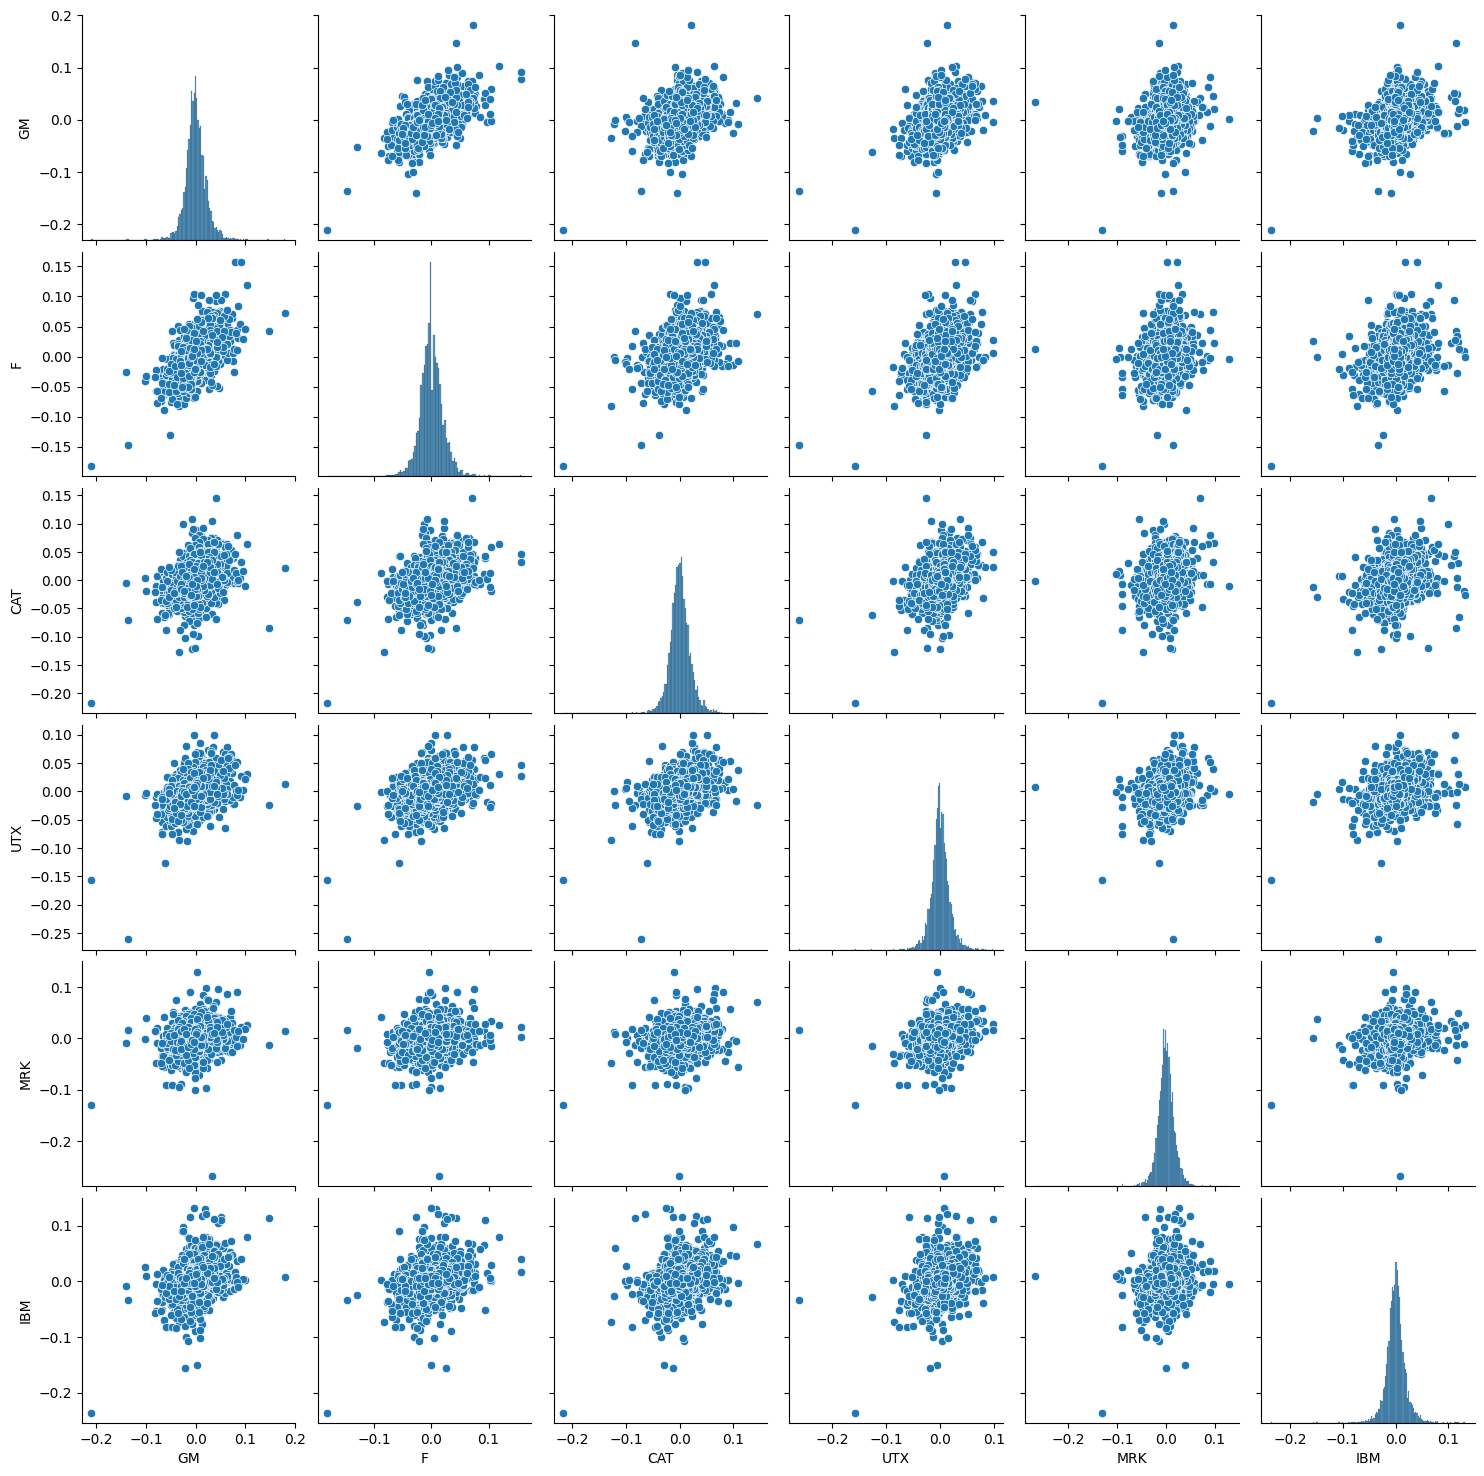

In [353]:
sns.pairplot(returns);

#### Problem 1

In [354]:
def calculate_statistics(returns):
    # calculate sample statistics
    mu = returns.mean().values.reshape(-1, 1)
    Sigma = returns.cov(ddof=1)
    sd = np.sqrt(np.diag(Sigma))
    return mu, Sigma, sd

In [355]:
def tangency_portfolio(rf, wP, muP, sdP):
    srP = (muP - rf) / sdP
    tangency_idx = np.nanargmax(srP)
    return tangency_idx, wP[tangency_idx], muP[tangency_idx], sdP[tangency_idx]

In [356]:
def minvar_portfolio(rf, wP, muP, sdP):
    minvar_idx = np.nanargmin(sdP)
    return minvar_idx, wP[minvar_idx], muP[minvar_idx], sdP[minvar_idx]

In [357]:
def calculate_efficient_frontier(returns, rf, mu, Sigma, w_lb, w_ub, rP_min, rP_max, n=200, verbose=False):
    # set up the optimisation problem
    w = cp.Variable(returns.shape[1])
    mu_P = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, Sigma)
    prob = cp.Problem(cp.Minimize(risk), [ret == mu_P, cp.sum(w) == 1, w_lb <= w, w <= w_ub])

    # helper function to solve the optimisation problem
    def solve_opt(mu_p):
        mu_P.value = mu_p
        prob.solve(solver=cp.ECOS)
        if prob.status != cp.OPTIMAL:
            if verbose:
                print(f'Unable to solve for {mu_p}: {prob.status}')
            return None
        else:
            return w.value, mu_p, np.sqrt(risk.value)

    # calculate the efficient frontier
    muP = np.linspace(rP_min, rP_max, n)
    wP = np.zeros((n, returns.shape[1]))
    sdP = np.zeros(n)
    for i, mu_p in enumerate(muP):
        solution = solve_opt(mu_p)
        if solution is None:
            wP[i, :] = np.nan
            sdP[i] = np.nan
        else:
            wP[i, :] = solution[0]
            sdP[i] = solution[2]
    
    return solve_opt, wP, muP, sdP

In [358]:
def plot_efficient_frontier(rf, wP, muP, sdP, mu, sd, names):
    # idenify the minvar and tangency portfolios
    minvar_idx, _, muP_minvar, sdP_minvar = minvar_portfolio(rf, wP, muP, sdP)
    efficient_mask = muP >= muP[minvar_idx]
    _, wP_tan, muP_tan, sdP_tan = tangency_portfolio(rf, wP, muP, sdP)

    # plot the efficient frontier, stocks, risk-free rate and the efficient line
    fig, ax = plt.subplots()
    ax.plot(sdP, muP, '--', color='gray', zorder=1);
    ax.plot(sdP[efficient_mask], muP[efficient_mask], color='r', zorder=2);
    ax.scatter(sd, mu, marker='x', color='orange');
    for r, s, name in zip(mu, sd, names):
        ax.annotate(name, (s, r));

    # risk-free rate
    ax.scatter(0, rf);
    # tangency portfolio
    ax.scatter(sdP_tan, muP_tan, marker='X', color='black', zorder=3);
    # efficient line
    ax.plot([0, sdP_tan * 1.5], [rf, (muP_tan - rf) * 1.5 + rf]);
    
    # minvar portfolio
    ax.scatter(sdP_minvar, muP_minvar, marker='+', color='g', zorder=3);

    ax.set_xlabel('$\sigma_P$');
    ax.set_ylabel('$r_P$');

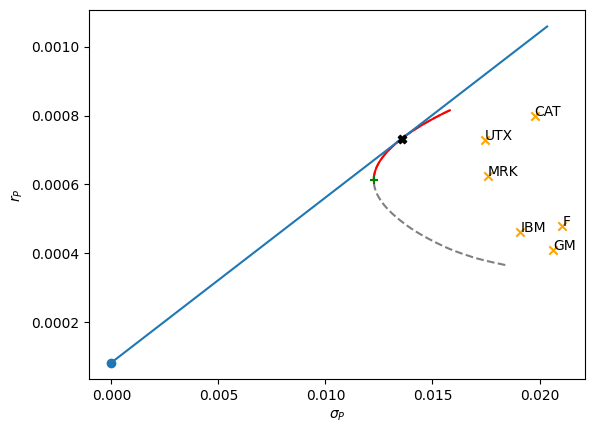

In [361]:
rf = 0.03 / 365
mu, Sigma, sd = calculate_statistics(returns)
solve_opt, wP, muP, sdP = calculate_efficient_frontier(returns, rf, mu, Sigma, -0.1, 0.5, 0.0003, 0.0010, n=300)
plot_efficient_frontier(rf, wP, muP, sdP, mu, sd, returns.columns)

In [330]:
tangency_portfolio(rf, wP, muP, sdP)

(185,
 array([-0.0903699 , -0.00246718,  0.33413405,  0.38289495,  0.31938924,
         0.05641885]),
 0.0007331103678929766,
 0.013570561764504146)

In [331]:
minvar_portfolio(rf, wP, muP, sdP)

(133,
 array([0.08457729, 0.05833795, 0.126779  , 0.23383452, 0.29574289,
        0.20072836]),
 0.000611371237458194,
 0.012255201005577466)

#### Problem 2

The optimal weights are:

In [303]:
pd.Series(solve_opt(0.0007)[0], index=prices.columns)

GM    -0.042689
F      0.013980
CAT    0.277758
UTX    0.342362
MRK    0.312944
IBM    0.095646
dtype: float64

#### Problem 3

The data set includes Black Monday:

In [304]:
returns.loc['1987-10-19']

GM    -0.210169
F     -0.182081
CAT   -0.216758
UTX   -0.156812
MRK   -0.129848
IBM   -0.235396
Name: 1987-10-19 00:00:00, dtype: float64

### 16.10.2 Efficient Portfolios with Apple, Exxon-Mobil, Target and McDonald's Stock

In [332]:
data = pd.read_csv('../data/FourStocks_Daily2013.csv', index_col=0, parse_dates=[0])
data.head()

,AAPL_Price,XOM_Price,TGT_Price,MCD_Price
Date,,,,
2013-01-02,75.26,84.58,56.09,85.10
2013-01-03,74.31,84.43,57.37,85.59
2013-01-04,72.24,84.82,57.77,84.85
2013-01-07,71.81,83.83,58.45,85.85
2013-01-08,72.01,84.36,57.82,85.88


In [333]:
data.index.min(), data.index.max()

(Timestamp('2013-01-02 00:00:00'), Timestamp('2013-12-31 00:00:00'))

In [334]:
prices = data
prices.columns = [col[:-6] for col in prices.columns]

In [335]:
returns = prices.pct_change().dropna()

#### Problem 4

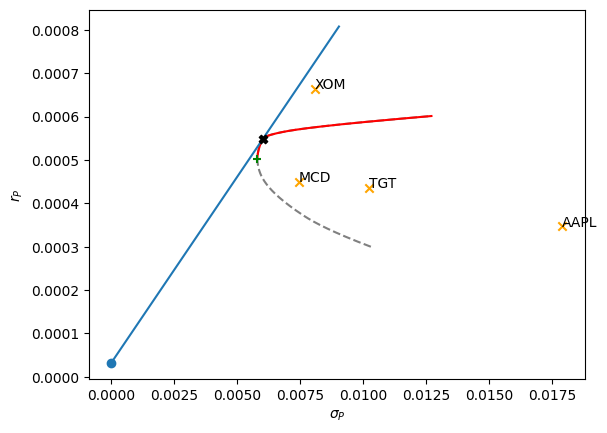

In [336]:
rf = 0.012 / 365
mu, Sigma, sd = calculate_statistics(returns)
solve_opt, wP, muP, sdP = calculate_efficient_frontier(returns, rf, mu, Sigma, -0.5, 0.5, 0.0003, 0.00065, n=500)
plot_efficient_frontier(rf, wP, muP, sdP, mu, sd, returns.columns)

The tangency portfolio:

In [341]:
idx_tan, wP_tan, muP_tan, sdP_tan = tangency_portfolio(rf, wP, muP, sdP)
idx_tan, wP_tan, muP_tan, sdP_tan

(356,
 array([0.0599995 , 0.49999316, 0.11293925, 0.3270681 ]),
 0.0005496993987975952,
 0.006025479577017412)

The weights in the tangency portfolio:

In [311]:
pd.Series(wP_tan, index=prices.columns)

AAPL    0.060000
XOM     0.499993
TGT     0.112939
MCD     0.327068
dtype: float64

The daily Sharpe ration of the tangency portfolio:

In [312]:
(muP_tan - rf) / sdP_tan

0.08577287166321343

The annual Sharpe ratio of the tangency portfolio:

In [313]:
(muP_tan - rf) / sdP_tan * np.sqrt(251)

1.3588978489393064

Minimum variance portfolio:

In [314]:
minvar_portfolio(rf, wP, muP, sdP)

(289,
 array([0.09336507, 0.30124373, 0.17899443, 0.42639677]),
 0.0005027054108216433,
 0.0057993112900546085)

#### Problem 5

In [345]:
def calculate_efficient_frontier_utility(returns, rf, mu, Sigma, w_lb, w_ub, loggamma_min, loggamma_max, n=200):
    # set up the optimisation problem
    w = cp.Variable(returns.shape[1])
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, Sigma)
    prob = cp.Problem(cp.Minimize(gamma * risk  - ret), [cp.sum(w) == 1, w_lb <= w, w <= w_ub])

    # helper function to solve the optimisation problem
    def solve_opt(g):
        gamma.value = g
        prob.solve(solver=cp.ECOS)
        if prob.status != cp.OPTIMAL:
            return None
        else:
            return w.value, ret.value[0], np.sqrt((w.T @ Sigma @ w).value)

    # calculate the efficient frontier
    loggammas = np.linspace(loggamma_min, loggamma_max, n)
    wP = np.zeros((n, returns.shape[1]))
    muP = np.zeros(n)
    sdP = np.zeros(n)
    for i, loggamma in enumerate(loggammas):
        solution = solve_opt(np.exp(loggamma))
        if solution is None:
            wP[i, :], muP[i], sdP[i] = np.nan, np.nan, np.nan
        else:
            wP[i, :], muP[i], sdP[i] = solution
    
    return solve_opt, wP, muP, sdP, np.exp(loggammas)

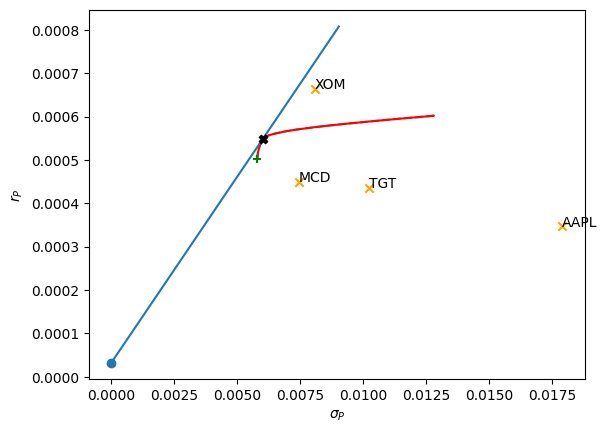

In [346]:
solve_opt, wP, muP, sdP, gammas = calculate_efficient_frontier_utility(returns, rf, mu, Sigma, -0.5, 0.5, -20, 10, n=200)
plot_efficient_frontier(rf, wP, muP, sdP, mu, sd, returns.columns)

In [347]:
tangency_portfolio(rf, wP, muP, sdP)

(146,
 array([0.0617651 , 0.49999991, 0.11320591, 0.32502908]),
 0.0005495154186100317,
 0.006023333323962275)

In [348]:
minvar_portfolio(rf, wP, muP, sdP)

(199,
 array([0.09356576, 0.3001106 , 0.17932358, 0.42700006]),
 0.0005024370570874373,
 0.005799302750113048)

Minimum variance portfolio is obtained at $\lambda \to \infty$ and has a return of:

In [317]:
minvar_portfolio(rf, wP, muP, sdP)[2]

0.0005024370570874373

Therefore, a return of 0.00046 cannot be obtained for any value of $\lambda$.

### 16.10.3 Finding the Set of Possible Expected Returns

In [363]:
data = pd.read_csv('../data/Stock_Bond.csv', index_col=0, parse_dates=[0], date_format='%d-%b-%y')
data.head()

,GM_Volume,GM_AC,F_Volume,F_AC,UTX_Volume,UTX_AC,CAT_Volume,CAT_AC,MRK_Volume,MRK_AC,...,XOM_Volume,XOM_AC,S&P_AC,S&P_Volume,1 year Treasury Constant Maturity Rate,3-Year Treasury Constant Maturity Rate,10 year Treasury Constant Maturity Rate,30 year Treasury Constant Maturity Rate,Aaa Bond Yield,Baa Bond Yield
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-02,922200,11.45,2540100,2.31,1130400,3.66,1218400,3.38,14454000,4.02,...,3611200,4.52,246.45,91880000,5.86,6.48,7.18,7.44,8.49,9.97
1987-01-05,2100000,11.73,8670000,2.40,3032800,3.70,1752000,3.48,11538000,4.10,...,9040000,4.63,252.19,181900000,5.85,6.41,7.08,7.35,8.44,9.90
1987-01-06,2720000,11.77,6992000,2.43,6614400,3.74,1206400,3.48,14279400,4.07,...,7931200,4.62,252.78,189300000,5.85,6.42,7.08,7.36,8.41,9.86
1987-01-07,2000400,11.83,7621200,2.53,4233600,3.78,2188000,3.45,13003200,4.08,...,5351200,4.61,255.33,190900000,5.78,6.37,7.05,7.33,8.40,9.82
1987-01-08,2460000,11.66,5807500,2.51,3816800,3.82,2195200,3.44,16320600,4.13,...,9680000,4.61,257.28,194500000,5.78,6.36,7.04,7.31,8.37,9.76


In [364]:
prices = data[['GM_AC', 'F_AC', 'CAT_AC', 'UTX_AC', 'MRK_AC', 'IBM_AC']]
prices.columns = [col[:-3] for col in prices.columns]

In [365]:
returns = prices.pct_change().dropna()

#### Problem 6

In [366]:
mu, Sigma, sd = calculate_statistics(returns)

In [376]:
def find_opt(w_lb, w_ub, obj):
    w = cp.Variable(returns.shape[1])
    prob = cp.Problem(obj(w.T @ mu), [cp.sum(w) == 1, -0.1 <= w, w <= 0.3])
    prob.solve()
    return prob.value, w.value

The minimum feasible return and corresponding weights:

In [382]:
find_opt(-0.1, 0.3, cp.Minimize)

(0.00043924399374301504,
 array([ 0.29999971,  0.29999963, -0.09999899, -0.09999827,  0.29999828,
         0.29999965]))

The maximum feasible weights and the corresponding weights:

In [383]:
find_opt(-0.1, 0.3, cp.Maximize)

(0.0007019599311944452,
 array([-0.09999975,  0.29999968,  0.29999997,  0.29999996,  0.29999993,
        -0.09999978]))

#### Problem 7

The constraint $\mathbf{w}^T \mathbf{1} = 1$ cannot be satisfied if $\mathbf{w} < \frac{1}{p}$, where $p$ is the number of variables, so setting the upper bound below $1/p$ leads to infeasibility.

In [384]:
1 / returns.shape[1]

0.16666666666666666